In [2]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import roc_auc_score, auc, roc_curve, accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, QuantileTransformer, KBinsDiscretizer, LabelEncoder, MinMaxScaler, PowerTransformer

import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use("ggplot")      
import seaborn as sns
import missingno as msno
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [3]:
# 数据读取，删除无效列

train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test1.csv')

train.drop(['Unnamed: 0'],axis=1,inplace=True)
test.drop(['Unnamed: 0'],axis=1,inplace=True)
train.head()

,android_id,apptype,carrier,dev_height,dev_ppi,dev_width,label,lan,media_id,ntt,os,osv,package,sid,timestamp,version,fea_hash,location,fea1_hash,cus_type
0,316361,1199,46000.0,0.0,0.0,0.0,1,NaN,104,6.0,android,9,18,1438873,1.559893e+12,8,2135019403,0,2329670524,601
1,135939,893,0.0,0.0,0.0,0.0,1,NaN,19,6.0,android,8.1,0,1185582,1.559994e+12,4,2782306428,1,2864801071,1000
2,399254,821,0.0,760.0,0.0,360.0,1,NaN,559,0.0,android,8.1.0,0,1555716,1.559837e+12,0,1392806005,2,628911675,696
3,68983,1004,46000.0,2214.0,0.0,1080.0,0,NaN,129,2.0,android,8.1.0,0,1093419,1.560042e+12,0,3562553457,3,1283809327,753
4,288999,1076,46000.0,2280.0,0.0,1080.0,1,zh-CN,64,2.0,android,8.0.0,0,1400089,1.559867e+12,5,2364522023,4,1510695983,582


In [4]:
train.describe()

,android_id,apptype,carrier,dev_height,dev_ppi,dev_width,label,media_id,ntt,package,sid,timestamp,location,fea1_hash,cus_type
count,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.00000,500000.00000,500000.000000,500000.000000,5.000000e+05,5.000000e+05,500000.000000,5.000000e+05,500000.000000
mean,261359.275126,986.640110,40028.788034,1264.986626,72.027966,703.486166,0.48448,124.08762,3.089808,38.465876,1.500335e+06,1.559814e+12,96.040504,2.300866e+09,730.824682
std,233616.172774,128.956348,15460.788899,853.371330,167.664930,505.751343,0.49976,164.25454,1.843088,136.321129,2.884292e+05,1.680735e+08,85.652740,1.236593e+09,331.946854
min,0.000000,95.000000,-1.000000,0.000000,0.000000,0.000000,0.00000,4.00000,0.000000,0.000000,1.000005e+06,1.559491e+12,-1.000000,1.240000e+04,297.000000
25%,0.000000,917.000000,46000.000000,720.000000,0.000000,360.000000,0.00000,29.00000,2.000000,0.000000,1.250850e+06,1.559664e+12,23.000000,1.376752e+09,411.000000
50%,228563.000000,1001.000000,46000.000000,1280.000000,0.000000,720.000000,0.00000,64.00000,2.000000,7.000000,1.500358e+06,1.559816e+12,64.000000,2.490131e+09,658.000000
75%,465701.500000,1076.000000,46000.000000,2040.000000,0.000000,1080.000000,1.00000,139.00000,5.000000,24.000000,1.750028e+06,1.559964e+12,154.000000,3.062465e+09,1019.000000
max,709898.000000,1241.000000,46003.000000,9024.000000,720.000000,8832.000000,1.00000,1544.00000,7.000000,2327.000000,1.999999e+06,1.560096e+12,330.000000,4.291920e+09,1380.000000


In [5]:
train.dtypes,len(train.columns)-1

(android_id      int64
 apptype         int64
 carrier       float64
 dev_height    float64
 dev_ppi       float64
 dev_width     float64
 label           int64
 lan            object
 media_id        int64
 ntt           float64
 os             object
 osv            object
 package         int64
 sid             int64
 timestamp     float64
 version        object
 fea_hash       object
 location        int64
 fea1_hash       int64
 cus_type        int64
 dtype: object,
 19)

TypeError: 'AxesSubplot' object is not callable

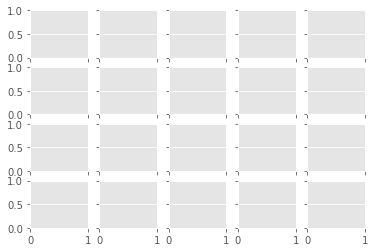

In [13]:
# 把各个特征的分布都用直方图画一下

fea_all = train.columns.tolist()
fea_all.remove('label')

# plt.figure()

fig, ax = plt.subplots(4, 5, sharex='col', sharey='row')

for i in range(4):
    for j in range(5):
        train[fea_all[i-1]].hist(ax[i, j])


# for i in range(1, 20):
#     plt.subplots(4, 5, i)
#     train[fea_all[i-1]].hist()
#     plt.title('{}'.format(fea_all[i-1]))
#     plt.show()



In [6]:
# from pandas_profiling import ProfileReport

# ProfileReport(train).to_notebook_iframe()